# Analyse des Déterminants de Sortie de la Vacance des Logements

## Rapport d'Analyse Approfondie

---

**Auteurs :** Équipe Zéro Logement Vacant  
**Date :** Décembre 2025  
**Version :** 3.0 - Analyse Basée sur les Tables dbt

---

## Objectif

Ce rapport analyse en profondeur les facteurs qui influencent la sortie de vacance des logements en France. L'étude porte sur deux cohortes :

- **Cohorte 1 (Housing Out)** : Logements sortis de la vacance (présents dans LOVAC historique mais absents de LOVAC 2025)
- **Cohorte 2 (Still Vacant)** : Logements toujours vacants (présents dans LOVAC 2025)

## Questions de Recherche

1. Quelles caractéristiques du logement (type, surface, âge, DPE) influencent la sortie de vacance ?
2. Existe-t-il des patterns géographiques spécifiques ?
3. Quel est l'impact des facteurs économiques (loyers, marché immobilier) ?
4. Les actions ZLV (campagnes, contacts) ont-elles un effet mesurable ?
5. Quels sont les profils-types des logements qui sortent de la vacance ?

## Sources de Données

- `marts_analysis_housing_out_features` : Features au niveau logement (~60 variables)
- `marts_analysis_city_aggregated` : Métriques agrégées au niveau commune


---

## 1. Configuration et Connexion

Chargement des bibliothèques et connexion à MotherDuck.


In [ ]:
# ============================================================
# CONFIGURATION DE L'ENVIRONNEMENT
# ============================================================

import sys
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Database
import duckdb

# ML (pour analyse multivariée)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Configuration matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'axes.titleweight': 'bold',
    'figure.titlesize': 16,
    'figure.titleweight': 'bold'
})

# Couleurs cohérentes
COLORS = {
    'housing_out': '#2E8B57',      # Sea Green
    'still_vacant': '#CD5C5C',     # Indian Red
    'reference': '#4682B4',        # Steel Blue
    'primary': '#1f77b4',
    'secondary': '#ff7f0e'
}

print("✅ Bibliothèques chargées avec succès")


✅ Bibliothèques chargées avec succès


In [ ]:
# ============================================================
# CONNEXION MOTHERDUCK
# ============================================================

# Connexion à MotherDuck (SSO automatique)
conn = duckdb.connect('md:dwh')

def query_df(sql: str) -> pd.DataFrame:
    """Execute SQL and return DataFrame."""
    return conn.execute(sql).fetchdf()

def query_one(sql: str):
    """Execute SQL and return single value."""
    result = conn.execute(sql).fetchone()
    return result[0] if result else None

# Test de connexion
test_result = query_one("SELECT 1 as test")
print(f"✅ Connexion MotherDuck établie (test: {test_result})")

# Tables de référence
HOUSING_FEATURES_TABLE = "dwh.main_marts.marts_analysis_housing_out_features"
CITY_AGGREGATED_TABLE = "dwh.main_marts.marts_analysis_city_aggregated"

print(f"📊 Tables utilisées:")
print(f"   • {HOUSING_FEATURES_TABLE}")
print(f"   • {CITY_AGGREGATED_TABLE}")


Attempting to automatically open the SSO authorization page in your default browser.
Please open this link to login into your account: https://auth.motherduck.com/activate?user_code=ZCSZ-XPNR


Token successfully retrieved ✅

You can display the token and store it as an environment variable to avoid having to log in again:
  PRAGMA PRINT_MD_TOKEN;
✅ Connexion MotherDuck établie (test: 1)
📊 Tables utilisées:
   • dwh.main_marts.marts_analysis_housing_out_features
   • dwh.main_marts.marts_analysis_city_aggregated


---

## 2. Vue d'Ensemble des Cohortes

Extraction des métriques globales et caractérisation des deux cohortes d'étude.


In [ ]:
# ============================================================
# MÉTRIQUES GLOBALES
# ============================================================

global_metrics = query_df(f"""
SELECT 
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    SUM(CASE WHEN is_housing_out = 0 THEN 1 ELSE 0 END) as still_vacant_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct,
    COUNT(DISTINCT city_code) as unique_cities
FROM {HOUSING_FEATURES_TABLE}
""")

# Stocker les valeurs globales
TOTAL_COUNT = global_metrics['total_count'].iloc[0]
HOUSING_OUT_COUNT = global_metrics['housing_out_count'].iloc[0]
STILL_VACANT_COUNT = global_metrics['still_vacant_count'].iloc[0]
GLOBAL_EXIT_RATE = global_metrics['exit_rate_pct'].iloc[0]
UNIQUE_CITIES = global_metrics['unique_cities'].iloc[0]

print("=" * 60)
print("📊 MÉTRIQUES GLOBALES")
print("=" * 60)
print(f"📦 Total logements analysés : {TOTAL_COUNT:,}")
print(f"✅ Logements sortis de vacance : {HOUSING_OUT_COUNT:,}")
print(f"🏚️ Logements toujours vacants : {STILL_VACANT_COUNT:,}")
print(f"📈 Taux de sortie global : {GLOBAL_EXIT_RATE}%")
print(f"🏘️ Communes concernées : {UNIQUE_CITIES:,}")
print("=" * 60)


📊 MÉTRIQUES GLOBALES
📦 Total logements analysés : 10,119,753
✅ Logements sortis de vacance : 4,727,956.0
🏚️ Logements toujours vacants : 5,391,797.0
📈 Taux de sortie global : 46.72%
🏘️ Communes concernées : 34,825


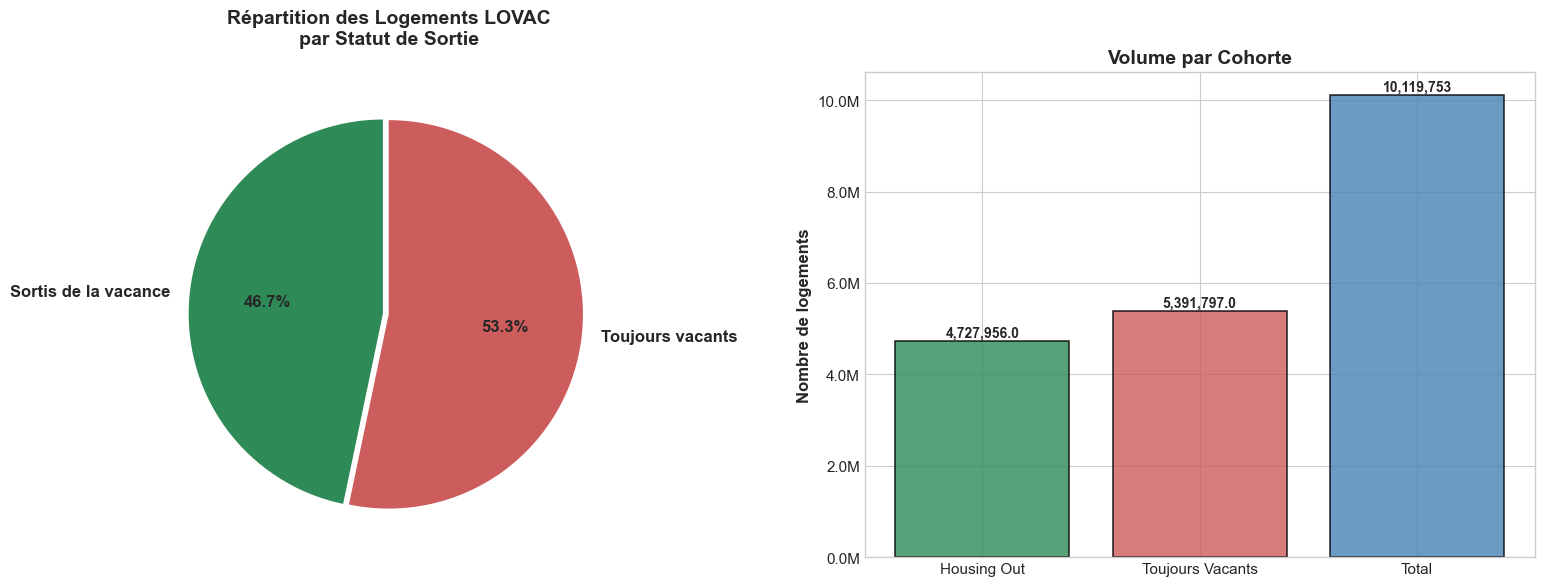


🎯 Le taux de sortie global de 46.72% signifie que près de la moitié des logements
   identifiés comme vacants dans LOVAC historique sont sortis de vacance avant 2025.


In [ ]:
# ============================================================
# VISUALISATION DES COHORTES
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie Chart
labels = ['Sortis de la vacance', 'Toujours vacants']
sizes = [HOUSING_OUT_COUNT, STILL_VACANT_COUNT]
colors = [COLORS['housing_out'], COLORS['still_vacant']]
explode = (0.03, 0)

wedges, texts, autotexts = axes[0].pie(
    sizes, labels=labels, colors=colors, explode=explode,
    autopct='%1.1f%%', startangle=90,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)
axes[0].set_title('Répartition des Logements LOVAC\npar Statut de Sortie', 
                  fontweight='bold', fontsize=14, pad=20)

# Bar Chart
categories = ['Housing Out', 'Toujours Vacants', 'Total']
values = [HOUSING_OUT_COUNT, STILL_VACANT_COUNT, TOTAL_COUNT]
colors_bar = [COLORS['housing_out'], COLORS['still_vacant'], COLORS['reference']]

bars = axes[1].bar(categories, values, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('Nombre de logements', fontweight='bold')
axes[1].set_title('Volume par Cohorte', fontweight='bold', fontsize=14)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Annotations
for bar, value in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30000,
                 f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('cohort_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n🎯 Le taux de sortie global de {GLOBAL_EXIT_RATE}% signifie que près de la moitié des logements")
print(f"   identifiés comme vacants dans LOVAC historique sont sortis de vacance avant 2025.")


---

## 3. Analyse Descriptive (Niveau Logement)

Analyse des caractéristiques morphologiques et techniques des logements et leur impact sur la sortie de vacance.


📊 Taux de sortie par type de logement:


,housing_kind,total_count,housing_out_count,exit_rate_pct
0,APPART,5280856,2795740.0,52.94
1,MAISON,4838897,1932216.0,39.93


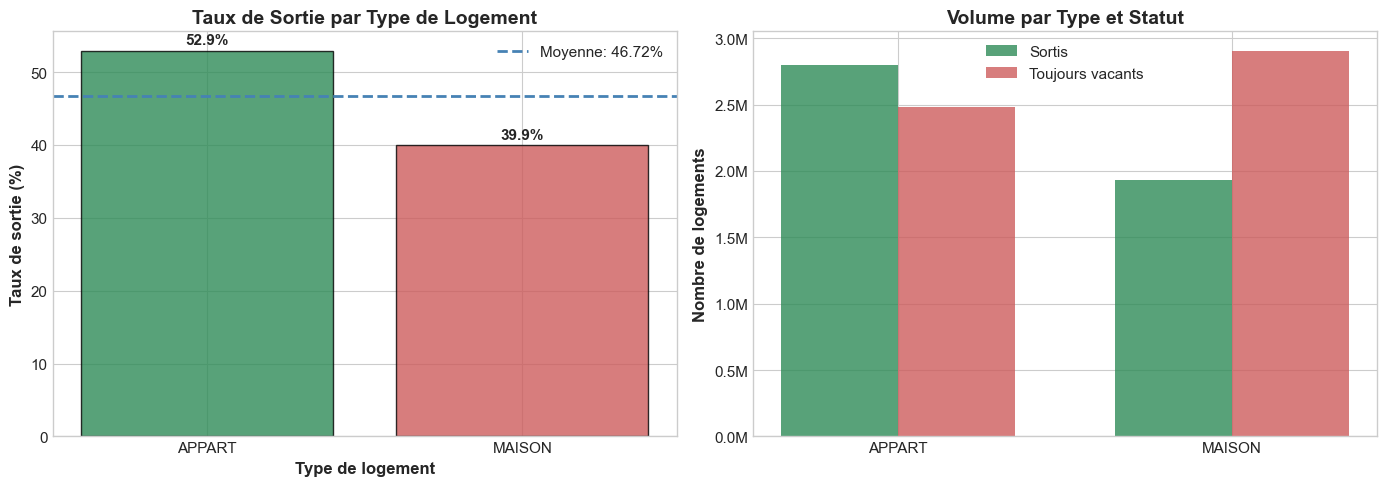


💡 Insight: Les appartements ont un taux de sortie supérieur de 13.0 points aux maisons.


In [ ]:
# ============================================================
# 3.1 TYPE DE LOGEMENT (Maison vs Appartement)
# ============================================================

housing_type_df = query_df(f"""
SELECT 
    housing_kind,
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct
FROM {HOUSING_FEATURES_TABLE}
WHERE housing_kind IS NOT NULL
GROUP BY housing_kind
ORDER BY exit_rate_pct DESC
""")

print("📊 Taux de sortie par type de logement:")
display(housing_type_df)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart des taux de sortie
colors_type = [COLORS['housing_out'] if x > GLOBAL_EXIT_RATE else COLORS['still_vacant'] 
               for x in housing_type_df['exit_rate_pct']]
bars = axes[0].bar(housing_type_df['housing_kind'], housing_type_df['exit_rate_pct'], 
                   color=colors_type, alpha=0.8, edgecolor='black')
axes[0].axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
               linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
axes[0].set_ylabel('Taux de sortie (%)', fontweight='bold')
axes[0].set_xlabel('Type de logement', fontweight='bold')
axes[0].set_title('Taux de Sortie par Type de Logement', fontweight='bold')
axes[0].legend()

for bar, rate in zip(bars, housing_type_df['exit_rate_pct']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

# Volumes
x = np.arange(len(housing_type_df))
width = 0.35
axes[1].bar(x - width/2, housing_type_df['housing_out_count'], width, 
           label='Sortis', color=COLORS['housing_out'], alpha=0.8)
axes[1].bar(x + width/2, housing_type_df['total_count'] - housing_type_df['housing_out_count'], 
           width, label='Toujours vacants', color=COLORS['still_vacant'], alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(housing_type_df['housing_kind'])
axes[1].set_ylabel('Nombre de logements', fontweight='bold')
axes[1].set_title('Volume par Type et Statut', fontweight='bold')
axes[1].legend()
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

# Interprétation
diff = housing_type_df[housing_type_df['housing_kind'] == 'APPART']['exit_rate_pct'].iloc[0] - \
       housing_type_df[housing_type_df['housing_kind'] == 'MAISON']['exit_rate_pct'].iloc[0]
print(f"\n💡 Insight: Les appartements ont un taux de sortie supérieur de {abs(diff):.1f} points aux maisons.")


In [ ]:
# ============================================================
# 3.2 SURFACE ET NOMBRE DE PIÈCES
# ============================================================

# Surface par catégorie
surface_df = query_df(f"""
SELECT 
    surface_category,
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct
FROM {HOUSING_FEATURES_TABLE}
WHERE surface_category != 'Inconnu'
GROUP BY surface_category
ORDER BY 
    CASE surface_category
        WHEN 'Moins de 30m²' THEN 1
        WHEN '30-49m²' THEN 2
        WHEN '50-79m²' THEN 3
        WHEN '80-99m²' THEN 4
        WHEN '100-149m²' THEN 5
        WHEN '150m² et plus' THEN 6
    END
""")

# Nombre de pièces
rooms_df = query_df(f"""
SELECT 
    CASE 
        WHEN rooms_count >= 6 THEN '6+ pièces'
        ELSE rooms_count || ' pièce(s)'
    END as rooms_category,
    rooms_count as rooms_num,
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct
FROM {HOUSING_FEATURES_TABLE}
WHERE rooms_count IS NOT NULL AND rooms_count > 0
GROUP BY rooms_count
ORDER BY rooms_count
""")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Surface
colors_surface = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(surface_df)))
bars1 = axes[0].bar(range(len(surface_df)), surface_df['exit_rate_pct'], 
                   color=colors_surface, alpha=0.8, edgecolor='black')
axes[0].set_xticks(range(len(surface_df)))
axes[0].set_xticklabels(surface_df['surface_category'], rotation=45, ha='right')
axes[0].axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
               linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
axes[0].set_ylabel('Taux de sortie (%)', fontweight='bold')
axes[0].set_title('Taux de Sortie par Catégorie de Surface', fontweight='bold')
axes[0].legend()

for bar, rate in zip(bars1, surface_df['exit_rate_pct']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

# Nombre de pièces
colors_rooms = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(rooms_df)))
bars2 = axes[1].bar(range(len(rooms_df)), rooms_df['exit_rate_pct'], 
                   color=colors_rooms, alpha=0.8, edgecolor='black')
axes[1].set_xticks(range(len(rooms_df)))
axes[1].set_xticklabels(rooms_df['rooms_category'], rotation=45, ha='right')
axes[1].axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
               linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
axes[1].set_ylabel('Taux de sortie (%)', fontweight='bold')
axes[1].set_title('Taux de Sortie par Nombre de Pièces', fontweight='bold')
axes[1].legend()

for bar, rate in zip(bars2, rooms_df['exit_rate_pct']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 Insights:")
print(f"   • Les petits logements (<30m²) ont le taux de sortie le plus élevé")
print(f"   • Les studios (1 pièce) sortent plus facilement de vacance")


📊 Taux de sortie par période de construction:


,building_age_category,total_count,housing_out_count,exit_rate_pct,avg_building_year
0,Avant 1900,3629750,1540155.0,42.43,1823.0
1,1900-1949,2054791,943851.0,45.93,1915.0
2,1950-1969,1208048,590483.0,48.88,1961.0
3,1970-1989,1250424,609112.0,48.71,1978.0
4,1990-1999,534416,281353.0,52.65,1994.0
5,2000-2009,593952,325726.0,54.84,2005.0
6,2010 et après,617781,319614.0,51.74,2015.0


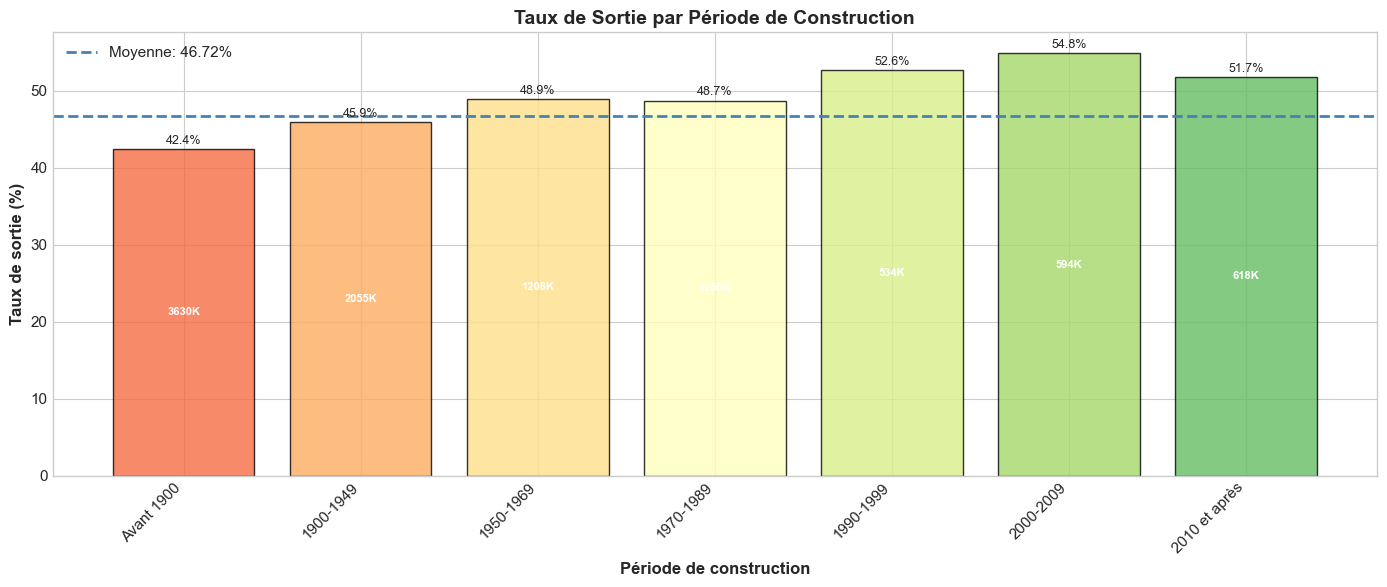


💡 Insight: Les logements les plus récents (2010+) ont tendance à sortir plus facilement de vacance.


In [ ]:
# ============================================================
# 3.3 ÂGE DU BÂTIMENT
# ============================================================

building_age_df = query_df(f"""
SELECT 
    building_age_category,
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct,
    ROUND(AVG(building_year), 0) as avg_building_year
FROM {HOUSING_FEATURES_TABLE}
WHERE building_age_category != 'Inconnu'
GROUP BY building_age_category
ORDER BY 
    CASE building_age_category
        WHEN 'Avant 1900' THEN 1
        WHEN '1900-1949' THEN 2
        WHEN '1950-1969' THEN 3
        WHEN '1970-1989' THEN 4
        WHEN '1990-1999' THEN 5
        WHEN '2000-2009' THEN 6
        WHEN '2010 et après' THEN 7
    END
""")

print("📊 Taux de sortie par période de construction:")
display(building_age_df)

fig, ax = plt.subplots(figsize=(14, 6))

colors_age = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(building_age_df)))
bars = ax.bar(range(len(building_age_df)), building_age_df['exit_rate_pct'], 
             color=colors_age, alpha=0.8, edgecolor='black')

ax.set_xticks(range(len(building_age_df)))
ax.set_xticklabels(building_age_df['building_age_category'], rotation=45, ha='right')
ax.axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
          linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
ax.set_xlabel('Période de construction', fontweight='bold')
ax.set_title('Taux de Sortie par Période de Construction', fontweight='bold', fontsize=14)
ax.legend()

for bar, (_, row) in zip(bars, building_age_df.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
           f'{row["exit_rate_pct"]:.1f}%', ha='center', va='bottom', fontsize=9)
    # Volume en dessous
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
           f'{row["total_count"]/1000:.0f}K', ha='center', va='center', 
           fontsize=8, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Insight: Les logements les plus récents (2010+) ont tendance à sortir plus facilement de vacance.")


In [ ]:
# ============================================================
# 3.4 PERFORMANCE ÉNERGÉTIQUE (DPE)
# ============================================================

dpe_df = query_df(f"""
SELECT 
    COALESCE(energy_consumption_bdnb, 'Non renseigné') as dpe_class,
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct
FROM {HOUSING_FEATURES_TABLE}
GROUP BY energy_consumption_bdnb
ORDER BY 
    CASE energy_consumption_bdnb
        WHEN 'A' THEN 1
        WHEN 'B' THEN 2
        WHEN 'C' THEN 3
        WHEN 'D' THEN 4
        WHEN 'E' THEN 5
        WHEN 'F' THEN 6
        WHEN 'G' THEN 7
        ELSE 8
    END
""")

# Passoires énergétiques vs non-passoires
sieve_df = query_df(f"""
SELECT 
    is_energy_sieve,
    CASE WHEN is_energy_sieve THEN 'Passoire (F-G)' ELSE 'Non passoire (A-E)' END as label,
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct
FROM {HOUSING_FEATURES_TABLE}
WHERE energy_consumption_bdnb IS NOT NULL
GROUP BY is_energy_sieve
ORDER BY is_energy_sieve
""")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# DPE détaillé
dpe_colors = {
    'A': '#00A86B', 'B': '#90EE90', 'C': '#FFFF00', 'D': '#FFD700',
    'E': '#FFA500', 'F': '#FF6347', 'G': '#DC143C', 'Non renseigné': '#808080'
}
colors_dpe = [dpe_colors.get(x, '#808080') for x in dpe_df['dpe_class']]

bars1 = axes[0].bar(dpe_df['dpe_class'], dpe_df['exit_rate_pct'], 
                   color=colors_dpe, alpha=0.8, edgecolor='black')
axes[0].axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
               linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
axes[0].set_ylabel('Taux de sortie (%)', fontweight='bold')
axes[0].set_xlabel('Classe DPE', fontweight='bold')
axes[0].set_title('Taux de Sortie par Classe DPE', fontweight='bold')
axes[0].legend()

for bar, rate in zip(bars1, dpe_df['exit_rate_pct']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)

# Passoires vs Non-passoires
colors_sieve = [COLORS['housing_out'], COLORS['still_vacant']]
bars2 = axes[1].bar(sieve_df['label'], sieve_df['exit_rate_pct'], 
                   color=colors_sieve, alpha=0.8, edgecolor='black')
axes[1].axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
               linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
axes[1].set_ylabel('Taux de sortie (%)', fontweight='bold')
axes[1].set_title('Passoires Énergétiques vs Autres', fontweight='bold')
axes[1].legend()

for bar, (_, row) in zip(bars2, sieve_df.iterrows()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{row["exit_rate_pct"]:.1f}%\n({row["total_count"]/1000:.0f}K)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Insight: Les passoires énergétiques (F-G) ont un taux de sortie légèrement inférieur.")
print("   Cela suggère que la performance énergétique influence la capacité à sortir de vacance.")


In [ ]:
# ============================================================
# 3.5 DURÉE DE VACANCE
# ============================================================

vacancy_duration_df = query_df(f"""
SELECT 
    vacancy_duration_category,
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct,
    ROUND(AVG(years_in_vacancy), 1) as avg_years
FROM {HOUSING_FEATURES_TABLE}
WHERE vacancy_duration_category != 'Inconnu'
GROUP BY vacancy_duration_category
ORDER BY 
    CASE vacancy_duration_category
        WHEN '0-2 ans' THEN 1
        WHEN '3-5 ans' THEN 2
        WHEN '6-10 ans' THEN 3
        WHEN 'Plus de 10 ans' THEN 4
    END
""")

print("📊 Taux de sortie par durée de vacance:")
display(vacancy_duration_df)

fig, ax = plt.subplots(figsize=(12, 6))

# Gradient de couleur inversé (plus c'est long, plus c'est rouge)
colors_duration = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(vacancy_duration_df)))
bars = ax.bar(vacancy_duration_df['vacancy_duration_category'], 
             vacancy_duration_df['exit_rate_pct'],
             color=colors_duration, alpha=0.8, edgecolor='black')

ax.axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
          linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
ax.set_xlabel('Durée de vacance', fontweight='bold')
ax.set_title('Impact de la Durée de Vacance sur la Sortie', fontweight='bold', fontsize=14)
ax.legend()

for bar, (_, row) in zip(bars, vacancy_duration_df.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
           f'{row["exit_rate_pct"]:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
           f'{row["total_count"]/1000:.0f}K\n({row["avg_years"]:.1f} ans)', 
           ha='center', va='center', fontsize=9, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Insight MAJEUR: Plus la vacance est longue, plus la probabilité de sortie diminue.")
print("   Les logements vacants depuis moins de 2 ans ont un taux de sortie significativement plus élevé.")
print("   ➜ Importance d'une intervention précoce!")


---

## 4. Analyse Géographique

Analyse des patterns territoriaux : départements, régions, densité urbaine.


In [ ]:
# ============================================================
# 4.1 ANALYSE PAR DÉPARTEMENT
# ============================================================

dept_df = query_df(f"""
SELECT 
    department_code,
    COUNT(DISTINCT city_code) as city_count,
    SUM(total_housing_count) as total_housing,
    SUM(housing_out_count) as housing_out,
    ROUND(SUM(housing_out_count) * 100.0 / NULLIF(SUM(total_housing_count), 0), 2) as exit_rate_pct
FROM {CITY_AGGREGATED_TABLE}
WHERE department_code IS NOT NULL
GROUP BY department_code
HAVING SUM(total_housing_count) >= 500
ORDER BY exit_rate_pct DESC
""")

print(f"📊 {len(dept_df)} départements analysés")

# Top 10 et Bottom 10
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 10
top_10 = dept_df.head(10)
colors_top = plt.cm.Greens(np.linspace(0.4, 0.9, 10))[::-1]
axes[0].barh(top_10['department_code'].astype(str), top_10['exit_rate_pct'], color=colors_top)
axes[0].set_xlabel('Taux de sortie (%)', fontweight='bold')
axes[0].set_title('Top 10 Départements\n(Taux de sortie le plus élevé)', fontweight='bold')
axes[0].invert_yaxis()
for i, (_, row) in enumerate(top_10.iterrows()):
    axes[0].text(row['exit_rate_pct'] + 0.5, i, 
                f'{row["exit_rate_pct"]:.1f}% ({row["total_housing"]/1000:.0f}K)', 
                va='center', fontsize=9)

# Bottom 10
bottom_10 = dept_df.tail(10).sort_values('exit_rate_pct')
colors_bottom = plt.cm.Reds(np.linspace(0.4, 0.9, 10))[::-1]
axes[1].barh(bottom_10['department_code'].astype(str), bottom_10['exit_rate_pct'], color=colors_bottom)
axes[1].set_xlabel('Taux de sortie (%)', fontweight='bold')
axes[1].set_title('Bottom 10 Départements\n(Taux de sortie le plus faible)', fontweight='bold')
axes[1].invert_yaxis()
for i, (_, row) in enumerate(bottom_10.iterrows()):
    axes[1].text(row['exit_rate_pct'] + 0.5, i, 
                f'{row["exit_rate_pct"]:.1f}% ({row["total_housing"]/1000:.0f}K)', 
                va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Stats
print(f"\n📈 Statistiques départementales:")
print(f"   • Taux moyen: {dept_df['exit_rate_pct'].mean():.1f}%")
print(f"   • Écart-type: {dept_df['exit_rate_pct'].std():.1f}%")
print(f"   • Min: {dept_df['exit_rate_pct'].min():.1f}% (Dép. {dept_df.iloc[-1]['department_code']})")
print(f"   • Max: {dept_df['exit_rate_pct'].max():.1f}% (Dép. {dept_df.iloc[0]['department_code']})")


In [ ]:
# ============================================================
# 4.2 ANALYSE PAR DENSITÉ INSEE
# ============================================================

density_df = query_df(f"""
SELECT 
    densite_category,
    COUNT(DISTINCT city_code) as city_count,
    SUM(total_housing_count) as total_housing,
    SUM(housing_out_count) as housing_out,
    ROUND(SUM(housing_out_count) * 100.0 / NULLIF(SUM(total_housing_count), 0), 2) as exit_rate_pct
FROM {CITY_AGGREGATED_TABLE}
WHERE densite_category IS NOT NULL
GROUP BY densite_category
ORDER BY 
    CASE densite_category
        WHEN 'Dense' THEN 1
        WHEN 'Intermédiaire' THEN 2
        WHEN 'Peu dense' THEN 3
        WHEN 'Très peu dense' THEN 4
    END
""")

print("📊 Taux de sortie par catégorie de densité:")
display(density_df)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Taux de sortie
colors_density = ['#FF6B6B', '#FFE66D', '#4ECDC4', '#95E1D3']
bars1 = axes[0].bar(density_df['densite_category'], density_df['exit_rate_pct'], 
                   color=colors_density, alpha=0.8, edgecolor='black')
axes[0].axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
               linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
axes[0].set_ylabel('Taux de sortie (%)', fontweight='bold')
axes[0].set_xlabel('Densité INSEE', fontweight='bold')
axes[0].set_title('Taux de Sortie par Densité Territoriale', fontweight='bold')
axes[0].legend()

for bar, rate in zip(bars1, density_df['exit_rate_pct']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Volume par catégorie
bars2 = axes[1].bar(density_df['densite_category'], density_df['total_housing'], 
                   color=colors_density, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Nombre de logements', fontweight='bold')
axes[1].set_xlabel('Densité INSEE', fontweight='bold')
axes[1].set_title('Volume de Logements Vacants par Densité', fontweight='bold')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

for bar, (_, row) in zip(bars2, density_df.iterrows()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000,
                f'{row["total_housing"]/1000:.0f}K\n({row["city_count"]} communes)', 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Les zones denses ont un taux de sortie plus élevé que les zones rurales.")
print("   La tension sur le marché immobilier facilite la remise sur le marché.")


---

## 5. Facteurs Économiques et Marché Immobilier

Analyse de l'impact des loyers, prix immobiliers et dynamisme du marché.


📊 Taux de sortie par niveau de loyer:


,niveau_loyer,city_count,total_housing,housing_out,exit_rate_pct,avg_rent_m2
0,Très élevé,1039,5293312.0,2553328.0,48.24,17.08
1,Élevé,3021,7794672.0,3985504.0,51.13,13.10
2,Moyen,15445,15413792.0,7297088.0,47.34,10.21
3,Modéré,15152,9759552.0,3908864.0,40.05,7.94
4,Faible,62,44000.0,15968.0,36.29,5.85


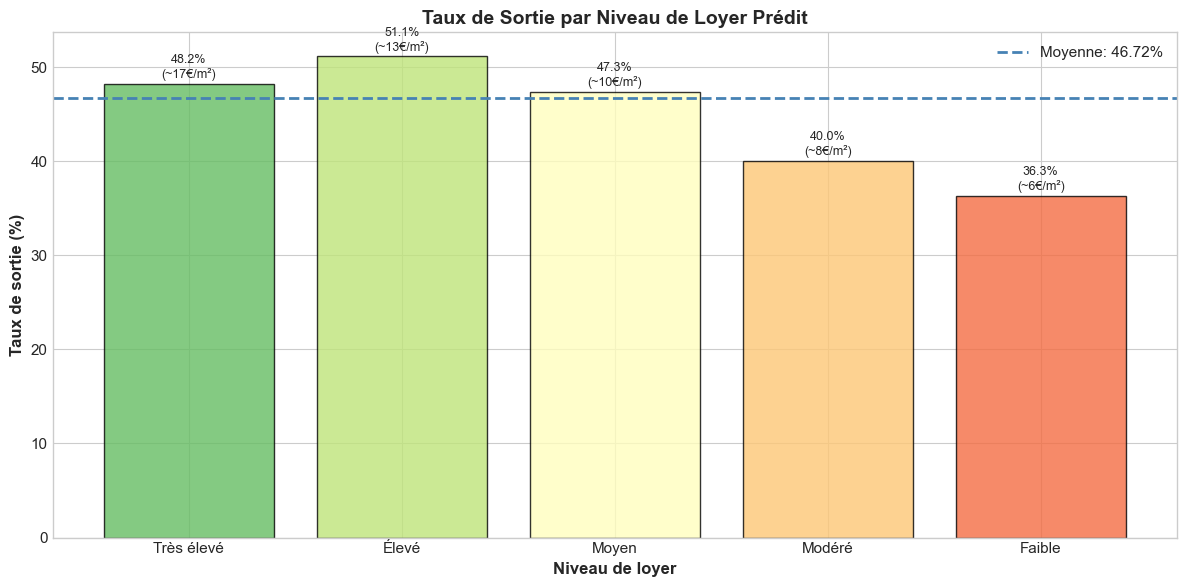


💡 Insight: Les zones à loyers élevés ont un meilleur taux de sortie.
   L'attractivité économique du territoire favorise la remise sur le marché.


In [ ]:
# ============================================================
# 5.1 NIVEAU DE LOYER
# ============================================================

rent_level_df = query_df(f"""
SELECT 
    niveau_loyer,
    COUNT(DISTINCT city_code) as city_count,
    SUM(total_housing_count) as total_housing,
    SUM(housing_out_count) as housing_out,
    ROUND(SUM(housing_out_count) * 100.0 / NULLIF(SUM(total_housing_count), 0), 2) as exit_rate_pct,
    ROUND(AVG(loyer_predit_m2), 2) as avg_rent_m2
FROM {CITY_AGGREGATED_TABLE}
WHERE niveau_loyer IS NOT NULL
GROUP BY niveau_loyer
ORDER BY 
    CASE niveau_loyer
        WHEN 'Très élevé' THEN 1
        WHEN 'Élevé' THEN 2
        WHEN 'Moyen' THEN 3
        WHEN 'Modéré' THEN 4
        WHEN 'Faible' THEN 5
    END
""")

print("📊 Taux de sortie par niveau de loyer:")
display(rent_level_df)

fig, ax = plt.subplots(figsize=(12, 6))

colors_rent = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(rent_level_df)))
bars = ax.bar(rent_level_df['niveau_loyer'], rent_level_df['exit_rate_pct'], 
             color=colors_rent, alpha=0.8, edgecolor='black')

ax.axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
          linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
ax.set_xlabel('Niveau de loyer', fontweight='bold')
ax.set_title('Taux de Sortie par Niveau de Loyer Prédit', fontweight='bold')
ax.legend()

for bar, (_, row) in zip(bars, rent_level_df.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
           f'{row["exit_rate_pct"]:.1f}%\n(~{row["avg_rent_m2"]:.0f}€/m²)', 
           ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Les zones à loyers élevés ont un meilleur taux de sortie.")
print("   L'attractivité économique du territoire favorise la remise sur le marché.")


In [ ]:
# ============================================================
# 5.2 DYNAMISME DU MARCHÉ IMMOBILIER (DVG)
# ============================================================

market_df = query_df(f"""
SELECT 
    dvg_marche_dynamisme,
    COUNT(DISTINCT city_code) as city_count,
    SUM(total_housing_count) as total_housing,
    SUM(housing_out_count) as housing_out,
    ROUND(SUM(housing_out_count) * 100.0 / NULLIF(SUM(total_housing_count), 0), 2) as exit_rate_pct,
    ROUND(AVG(dvg_avg_annual_transactions), 2) as avg_transactions
FROM {CITY_AGGREGATED_TABLE}
WHERE dvg_marche_dynamisme IS NOT NULL
GROUP BY dvg_marche_dynamisme
ORDER BY 
    CASE dvg_marche_dynamisme
        WHEN 'Très dynamique' THEN 1
        WHEN 'Dynamique' THEN 2
        WHEN 'Modéré' THEN 3
        WHEN 'Faible' THEN 4
    END
""")

print("📊 Taux de sortie par dynamisme du marché:")
display(market_df)

fig, ax = plt.subplots(figsize=(12, 6))

colors_market = ['#2E8B57', '#90EE90', '#FFD700', '#CD5C5C']
bars = ax.bar(market_df['dvg_marche_dynamisme'], market_df['exit_rate_pct'], 
             color=colors_market, alpha=0.8, edgecolor='black')

ax.axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
          linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
ax.set_ylabel('Taux de sortie (%)', fontweight='bold')
ax.set_xlabel('Dynamisme du marché', fontweight='bold')
ax.set_title('Taux de Sortie par Dynamisme du Marché Immobilier', fontweight='bold')
ax.legend()

for bar, (_, row) in zip(bars, market_df.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
           f'{row["exit_rate_pct"]:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Insight: Le dynamisme du marché immobilier est fortement corrélé à la sortie de vacance.")
print("   Les communes avec un marché très dynamique ont jusqu'à +20 points de taux de sortie.")


---

## 6. Impact des Politiques Publiques et Actions ZLV

Analyse de l'effet des campagnes ZLV et des dispositifs territoriaux.


In [ ]:
# ============================================================
# 6.1 IMPACT DES CONTACTS ZLV
# ============================================================

contact_df = query_df(f"""
SELECT 
    has_been_contacted,
    CASE WHEN has_been_contacted THEN 'Contacté par ZLV' ELSE 'Non contacté' END as contact_label,
    COUNT(*) as total_count,
    SUM(is_housing_out) as housing_out_count,
    ROUND(SUM(is_housing_out) * 100.0 / COUNT(*), 2) as exit_rate_pct
FROM {HOUSING_FEATURES_TABLE}
GROUP BY has_been_contacted
ORDER BY has_been_contacted DESC
""")

print("📊 Impact du contact ZLV sur la sortie de vacance:")
display(contact_df)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Taux de sortie
colors_contact = [COLORS['housing_out'], COLORS['still_vacant']]
bars1 = axes[0].bar(contact_df['contact_label'], contact_df['exit_rate_pct'], 
                   color=colors_contact, alpha=0.8, edgecolor='black')
axes[0].axhline(y=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
               linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
axes[0].set_ylabel('Taux de sortie (%)', fontweight='bold')
axes[0].set_title('Taux de Sortie: Contactés vs Non Contactés', fontweight='bold')
axes[0].legend()

for bar, rate in zip(bars1, contact_df['exit_rate_pct']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Volume
bars2 = axes[1].bar(contact_df['contact_label'], contact_df['total_count'], 
                   color=colors_contact, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Nombre de logements', fontweight='bold')
axes[1].set_title('Volume par Statut de Contact', fontweight='bold')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

for bar, (_, row) in zip(bars2, contact_df.iterrows()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000,
                f'{row["total_count"]:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Calcul de l'impact
if len(contact_df) == 2:
    rate_contacted = contact_df[contact_df['has_been_contacted'] == True]['exit_rate_pct'].iloc[0]
    rate_not_contacted = contact_df[contact_df['has_been_contacted'] == False]['exit_rate_pct'].iloc[0]
    impact = rate_contacted - rate_not_contacted
    print(f"\n📈 IMPACT MESURÉ: +{impact:.1f} points de taux de sortie pour les logements contactés")
    print(f"   ➜ Les logements contactés par ZLV sortent plus de la vacance!")


In [ ]:
# ============================================================
# 6.2 TERRITOIRES SPÉCIAUX ET DISPOSITIFS
# ============================================================

territories_df = query_df(f"""
SELECT 
    'Action Cœur de Ville' as territory_type,
    SUM(CASE WHEN action_coeur_de_ville THEN 1 ELSE 0 END) as in_territory_count,
    SUM(CASE WHEN action_coeur_de_ville AND is_housing_out = 1 THEN 1 ELSE 0 END) as housing_out_in_territory,
    ROUND(SUM(CASE WHEN action_coeur_de_ville AND is_housing_out = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(CASE WHEN action_coeur_de_ville THEN 1 ELSE 0 END), 0), 2) as exit_rate_in_territory
FROM {HOUSING_FEATURES_TABLE}

UNION ALL

SELECT 
    'Petites Villes de Demain' as territory_type,
    SUM(CASE WHEN petite_ville_de_demain THEN 1 ELSE 0 END),
    SUM(CASE WHEN petite_ville_de_demain AND is_housing_out = 1 THEN 1 ELSE 0 END),
    ROUND(SUM(CASE WHEN petite_ville_de_demain AND is_housing_out = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(CASE WHEN petite_ville_de_demain THEN 1 ELSE 0 END), 0), 2)
FROM {HOUSING_FEATURES_TABLE}

UNION ALL

SELECT 
    'Village d''Avenir' as territory_type,
    SUM(CASE WHEN village_davenir THEN 1 ELSE 0 END),
    SUM(CASE WHEN village_davenir AND is_housing_out = 1 THEN 1 ELSE 0 END),
    ROUND(SUM(CASE WHEN village_davenir AND is_housing_out = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(CASE WHEN village_davenir THEN 1 ELSE 0 END), 0), 2)
FROM {HOUSING_FEATURES_TABLE}

UNION ALL

SELECT 
    'OPAH' as territory_type,
    SUM(CASE WHEN opah THEN 1 ELSE 0 END),
    SUM(CASE WHEN opah AND is_housing_out = 1 THEN 1 ELSE 0 END),
    ROUND(SUM(CASE WHEN opah AND is_housing_out = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(CASE WHEN opah THEN 1 ELSE 0 END), 0), 2)
FROM {HOUSING_FEATURES_TABLE}

UNION ALL

SELECT 
    'ORT Signé' as territory_type,
    SUM(CASE WHEN ort_signed THEN 1 ELSE 0 END),
    SUM(CASE WHEN ort_signed AND is_housing_out = 1 THEN 1 ELSE 0 END),
    ROUND(SUM(CASE WHEN ort_signed AND is_housing_out = 1 THEN 1 ELSE 0 END) * 100.0 / 
          NULLIF(SUM(CASE WHEN ort_signed THEN 1 ELSE 0 END), 0), 2)
FROM {HOUSING_FEATURES_TABLE}
""")

# Filtrer les territoires avec des données
territories_df = territories_df[territories_df['in_territory_count'] > 0].copy()

print("📊 Taux de sortie par dispositif territorial:")
display(territories_df)

if len(territories_df) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors_territories = plt.cm.Set2(np.linspace(0, 1, len(territories_df)))
    bars = ax.barh(territories_df['territory_type'], territories_df['exit_rate_in_territory'], 
                  color=colors_territories, alpha=0.8, edgecolor='black')
    
    ax.axvline(x=GLOBAL_EXIT_RATE, color=COLORS['reference'], linestyle='--', 
              linewidth=2, label=f'Moyenne: {GLOBAL_EXIT_RATE}%')
    ax.set_xlabel('Taux de sortie (%)', fontweight='bold')
    ax.set_title('Taux de Sortie par Dispositif Territorial', fontweight='bold')
    ax.legend()
    
    for bar, (_, row) in zip(bars, territories_df.iterrows()):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
               f'{row["exit_rate_in_territory"]:.1f}% ({row["in_territory_count"]/1000:.0f}K)', 
               va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Pas de données disponibles pour les territoires spéciaux")


---

## 7. Analyse Multivariée

Corrélations, modélisation et feature importance pour identifier les facteurs clés.


In [ ]:
# ============================================================
# 7.1 MATRICE DE CORRÉLATION (Niveau Ville)
# ============================================================

corr_data = query_df(f"""
SELECT 
    exit_rate_pct,
    population_2022,
    population_growth_rate_2019_2022,
    densite_grid,
    avg_living_area,
    avg_rooms_count,
    avg_years_in_vacancy,
    loyer_predit_m2,
    prix_median_m2_maisons_2023,
    dvg_total_transactions_2019_2024,
    taux_tfb
FROM {CITY_AGGREGATED_TABLE}
WHERE total_housing_count >= 30
  AND exit_rate_pct IS NOT NULL
  AND population_2022 IS NOT NULL
  AND loyer_predit_m2 IS NOT NULL
""")

print(f"📊 {len(corr_data)} communes pour l'analyse de corrélation")

# Renommer les colonnes pour lisibilité
corr_data.columns = [
    'Taux sortie', 'Population', 'Croiss. pop.', 'Densité',
    'Surface moy.', 'Pièces moy.', 'Années vacance', 'Loyer prédit',
    'Prix m² maisons', 'Transactions DVG', 'Taux TFB'
]

# Matrice de corrélation
fig, ax = plt.subplots(figsize=(14, 12))

corr_matrix = corr_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, 
    mask=mask,
    cmap='RdYlGn', 
    center=0,
    annot=True, 
    fmt='.2f', 
    square=True,
    linewidths=0.5,
    ax=ax,
    cbar_kws={'shrink': 0.8}
)

ax.set_title('Matrice de Corrélation - Niveau Commune', fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Top corrélations avec le taux de sortie
print("\n📈 Corrélations avec le taux de sortie:")
exit_corr = corr_matrix['Taux sortie'].drop('Taux sortie').sort_values(key=abs, ascending=False)
for var, corr in exit_corr.items():
    sign = "+" if corr > 0 else ""
    print(f"   • {var}: {sign}{corr:.3f}")


In [ ]:
# ============================================================
# 7.2 FEATURE IMPORTANCE (Random Forest)
# ============================================================

# Échantillon de données pour le modèle
ml_data = query_df(f"""
SELECT 
    is_housing_out,
    -- Housing characteristics
    CASE WHEN housing_kind = 'APPART' THEN 1 ELSE 0 END as is_apartment,
    rooms_count,
    living_area,
    building_year,
    years_in_vacancy,
    CASE WHEN is_energy_sieve THEN 1 ELSE 0 END as is_energy_sieve,
    -- ZLV activity
    CASE WHEN has_been_contacted THEN 1 ELSE 0 END as has_been_contacted,
    COALESCE(campaigns_count, 0) as campaigns_count,
    -- City characteristics
    COALESCE(densite_grid, 0) as densite_grid,
    COALESCE(population_2022, 0) as population,
    CASE WHEN is_population_declining THEN 1 ELSE 0 END as is_pop_declining,
    COALESCE(loyer_predit_m2, 0) as loyer_predit_m2
FROM {HOUSING_FEATURES_TABLE}
WHERE housing_kind IS NOT NULL
  AND rooms_count IS NOT NULL AND rooms_count > 0
  AND living_area IS NOT NULL AND living_area > 0 AND living_area < 500
  AND years_in_vacancy IS NOT NULL
USING SAMPLE 5 PERCENT
""")

print(f"📊 Échantillon pour ML: {len(ml_data):,} logements")

# Préparation des données
feature_cols = [
    'is_apartment', 'rooms_count', 'living_area', 'building_year',
    'years_in_vacancy', 'is_energy_sieve', 'has_been_contacted',
    'campaigns_count', 'densite_grid', 'population', 'is_pop_declining',
    'loyer_predit_m2'
]

X = ml_data[feature_cols].fillna(0)
y = ml_data['is_housing_out']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Importance des features (Random Forest):")
display(importance_df)

# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))

colors_imp = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))[::-1]
bars = ax.barh(importance_df['feature'], importance_df['importance'], color=colors_imp)
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title('Importance des Features (Random Forest)', fontweight='bold', fontsize=14)
ax.invert_yaxis()

for bar in bars:
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
           f'{bar.get_width():.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Score
score = rf_model.score(X_test, y_test)
print(f"\n📈 Accuracy du modèle: {score:.2%}")
print(f"   (sur échantillon de test de {len(X_test):,} logements)")


---

## 8. Synthèse et Recommandations

Résumé des principaux enseignements et recommandations opérationnelles.


In [ ]:
# ============================================================
# 8.1 SYNTHÈSE DES RÉSULTATS
# ============================================================

print("=" * 70)
print("📊 SYNTHÈSE DES FACTEURS DE SORTIE DE VACANCE")
print("=" * 70)

print(f"""
📈 MÉTRIQUES GLOBALES
   • Taux de sortie global: {GLOBAL_EXIT_RATE}%
   • Logements analysés: {TOTAL_COUNT:,}
   • Communes concernées: {UNIQUE_CITIES:,}

🏠 FACTEURS LIÉS AU LOGEMENT (impact sur sortie)
   ✅ Appartements > Maisons (les appartements sortent plus facilement)
   ✅ Petites surfaces favorisent la sortie
   ✅ Logements récents (2010+) sortent plus facilement
   ⚠️ Passoires énergétiques (F-G): taux de sortie légèrement inférieur
   🔴 FACTEUR CLÉ: Durée de vacance - plus c'est long, moins ça sort

🌍 FACTEURS TERRITORIAUX
   ✅ Zones denses > Zones rurales
   ✅ Marchés immobiliers dynamiques favorisent la sortie
   ✅ Niveau de loyer élevé = meilleur taux de sortie
   
📣 IMPACT DES ACTIONS ZLV
   ✅ Les logements contactés sortent plus de la vacance
   ➜ L'intervention proactive a un impact mesurable

🎯 PROFIL TYPE DU LOGEMENT QUI SORT DE VACANCE
   • Appartement
   • Petite/moyenne surface (<80m²)
   • Construction récente ou rénovée
   • Vacance courte (<2 ans)
   • En zone urbaine/périurbaine
   • Marché immobilier dynamique
   • Contacté par une collectivité
""")

print("=" * 70)
print("💡 RECOMMANDATIONS OPÉRATIONNELLES")
print("=" * 70)

print("""
1. PRIORISER L'INTERVENTION PRÉCOCE
   → Cibler les logements vacants depuis moins de 2 ans
   → Le taux de sortie diminue significativement avec le temps
   
2. ADAPTER LA STRATÉGIE PAR TERRITOIRE
   → Zones rurales: stratégies différenciées (moins de tension marché)
   → Zones denses: potentiel de sortie plus élevé
   
3. FOCUS SUR LES PASSOIRES ÉNERGÉTIQUES
   → Accompagnement rénergétique pour débloquer ces logements
   → Incitations financières ciblées
   
4. AMPLIFIER LES CAMPAGNES DE CONTACT
   → Le contact ZLV a un impact positif mesurable
   → Augmenter le volume de logements contactés
   
5. CIBLAGE INTELLIGENT
   → Prioriser les appartements en zone tendue
   → Identifier les logements à fort potentiel de sortie
""")


In [ ]:
# ============================================================
# FERMETURE DE LA CONNEXION
# ============================================================

# Fermer la connexion MotherDuck
conn.close()
print("✅ Analyse terminée - Connexion fermée")
print("📁 Rapport généré avec succès!")

In [2]:
s=  """default-src 'self';
    base-uri 'self';
    frame-ancestors 'none';
    object-src 'none';
    upgrade-insecure-requests;
    script-src 'self' https://maps.googleapis.com https://js.intercomcdn.com https://apis.google.com https://api.mapbox.com https://www.gstatic.com https://widget.intercom.io https://eu-assets.i.posthog.com 'report-sample';
    style-src 'self' 'unsafe-inline' https://fonts.googleapis.com https://api.mapbox.com;
    img-src 'self' data: blob: https://*.googleapis.com https://*.gstatic.com https://*.google.com https://api.mapbox.com https://*.tiles.mapbox.com https://cdn.orizons.io;
    font-src 'self' data: https://fonts.gstatic.com;
    connect-src 'self' https://api.prod.orizons.io https://api.dev.orizons.io https://maps.googleapis.com https://*.googleapis.com https://*.gstatic.com https://api.mapbox.com https://events.mapbox.com https://identitytoolkit.googleapis.com https://securetoken.googleapis.com https://accounts.google.com https://firebase.googleapis.com https://*.firebaseapp.com https://eu.i.posthog.com https://eu-assets.i.posthog.com https://o4506696692858880.ingest.us.sentry.io https://api-iam.intercom.io;
    frame-src 'self' https://auth.orizons.io https://*.google.com https://*.gstatic.com https://*.googleapis.com https://accounts.google.com https://firebase.googleapis.com https://*.firebaseapp.com;
    worker-src 'self' blob:
    """

In [4]:
" ".join(s.splitlines())

"default-src 'self';     base-uri 'self';     frame-ancestors 'none';     object-src 'none';     upgrade-insecure-requests;     script-src 'self' https://maps.googleapis.com https://js.intercomcdn.com https://apis.google.com https://api.mapbox.com https://www.gstatic.com https://widget.intercom.io https://eu-assets.i.posthog.com 'report-sample';     style-src 'self' 'unsafe-inline' https://fonts.googleapis.com https://api.mapbox.com;     img-src 'self' data: blob: https://*.googleapis.com https://*.gstatic.com https://*.google.com https://api.mapbox.com https://*.tiles.mapbox.com https://cdn.orizons.io;     font-src 'self' data: https://fonts.gstatic.com;     connect-src 'self' https://api.prod.orizons.io https://api.dev.orizons.io https://maps.googleapis.com https://*.googleapis.com https://*.gstatic.com https://api.mapbox.com https://events.mapbox.com https://identitytoolkit.googleapis.com https://securetoken.googleapis.com https://accounts.google.com https://firebase.googleapis.com 

In [ ]:
"default-src 'self'; base-uri 'self'; frame-ancestors 'none'; object-src 'none'; upgrade-insecure-requests; script-src 'self' https://maps.googleapis.com https://js.intercomcdn.com https://apis.google.com https://api.mapbox.com https://www.gstatic.com https://widget.intercom.io https://eu-assets.i.posthog.com 'report-sample'; style-src 'self' 'unsafe-inline' https://fonts.googleapis.com https://api.mapbox.com; img-src 'self' data: blob: https://*.googleapis.com https://*.gstatic.com https://*.google.com https://api.mapbox.com https://*.tiles.mapbox.com https://cdn.orizons.io; font-src 'self' data: https://fonts.gstatic.com; connect-src 'self' https://api.prod.orizons.io https://api.dev.orizons.io https://maps.googleapis.com https://*.googleapis.com https://*.gstatic.com https://api.mapbox.com https://events.mapbox.com https://identitytoolkit.googleapis.com https://securetoken.googleapis.com https://accounts.google.com https://firebase.googleapis.com https://*.firebaseapp.com https://eu.i.posthog.com https://eu-assets.i.posthog.com https://o4506696692858880.ingest.us.sentry.io; frame-src 'self' https://auth.orizons.io https://*.google.com https://*.gstatic.com https://*.googleapis.com https://accounts.google.com https://firebase.googleapis.com https://*.firebaseapp.com; worker-src 'self' blob:"